In [7]:
import os
os.listdir("/kaggle/input")
os.listdir("/kaggle/input/Medical-Equipments-Cost-Prediction-Challenge")
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score


CLIP_FLOOR = 1.0 # Clip negative/zero costs to this value before log transform
FREQ_THRESHOLD = 0.015 # Group categories with frequency < 1.5% (for robustness)


train_df = pd.read_csv("/kaggle/input/Medical-Equipments-Cost-Prediction-Challenge/train.csv")
test_df = pd.read_csv("/kaggle/input/Medical-Equipments-Cost-Prediction-Challenge/test.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Hospital_Id           5000 non-null   object 
 1   Supplier_Name         5000 non-null   object 
 2   Supplier_Reliability  4413 non-null   float64
 3   Equipment_Height      4717 non-null   float64
 4   Equipment_Width       4557 non-null   float64
 5   Equipment_Weight      4540 non-null   float64
 6   Equipment_Type        4401 non-null   object 
 7   Equipment_Value       5000 non-null   float64
 8   Base_Transport_Fee    5000 non-null   float64
 9   CrossBorder_Shipping  5000 non-null   object 
 10  Urgent_Shipping       5000 non-null   object 
 11  Installation_Service  5000 non-null   object 
 12  Transport_Method      3929 non-null   object 
 13  Fragile_Equipment     5000 non-null   object 
 14  Hospital_Info         5000 non-null   object 
 15  Rural_Hospital       

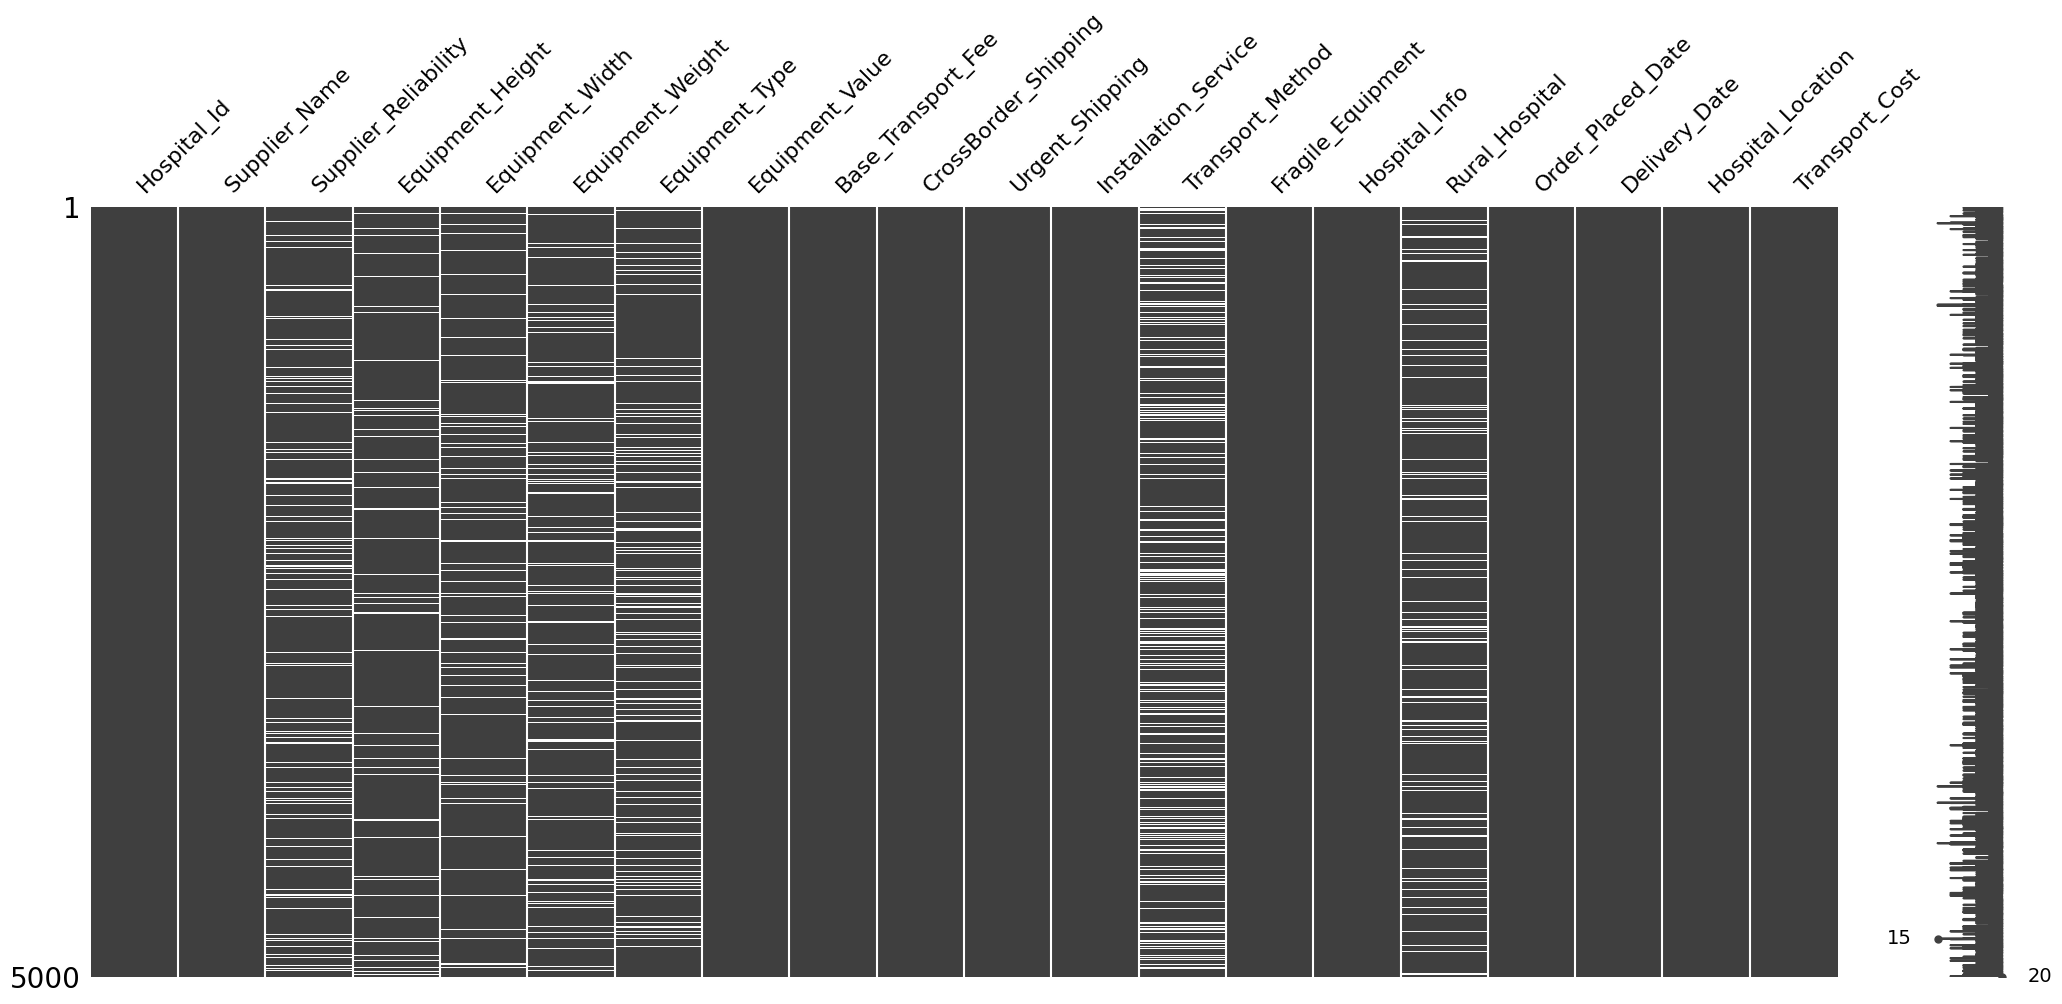

/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


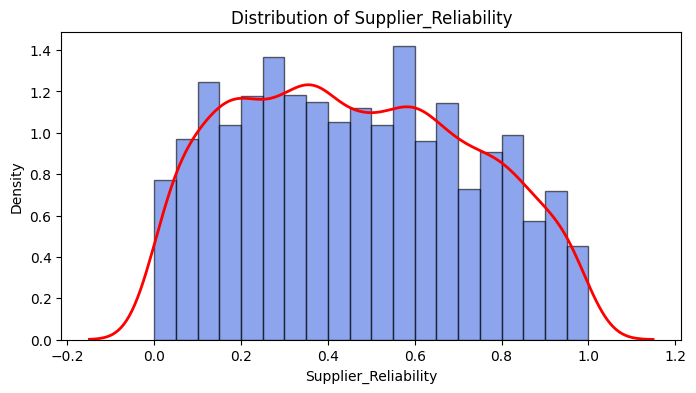

/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


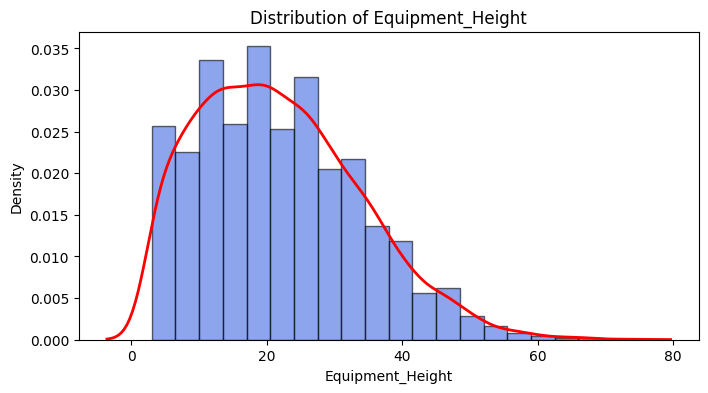

/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


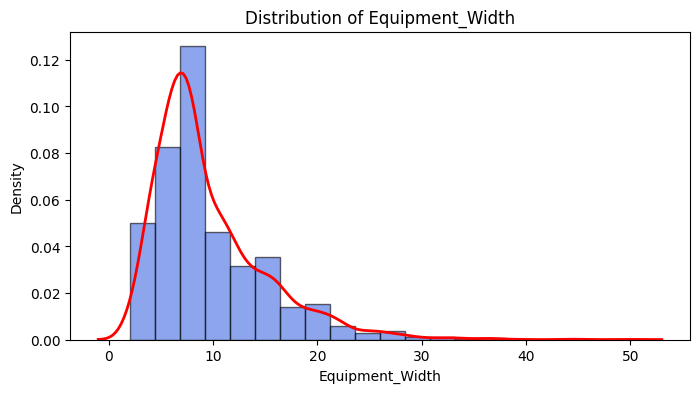

/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


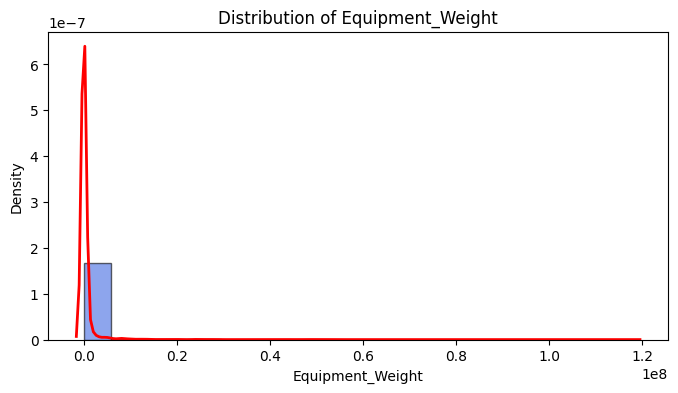

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


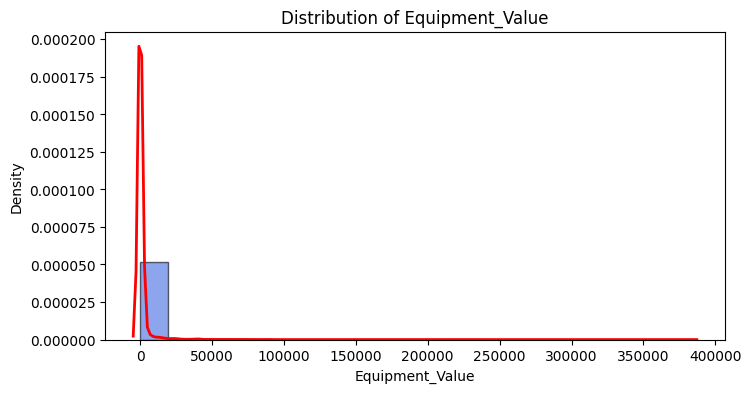

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


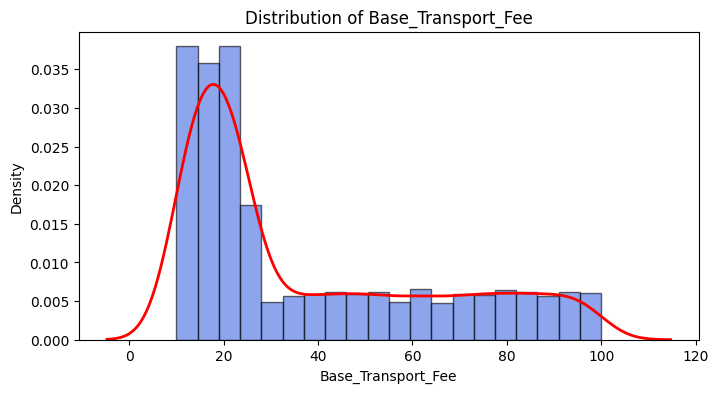

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


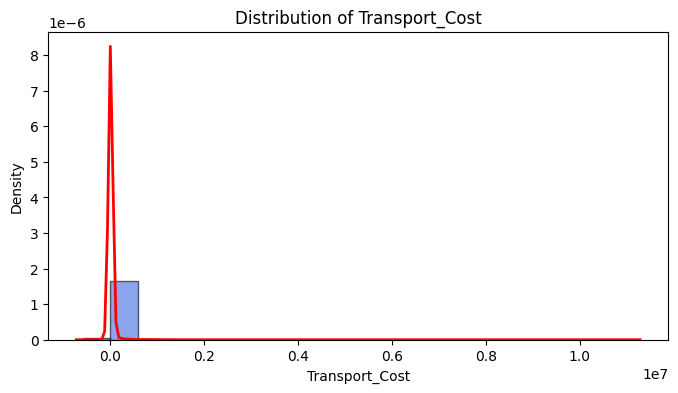

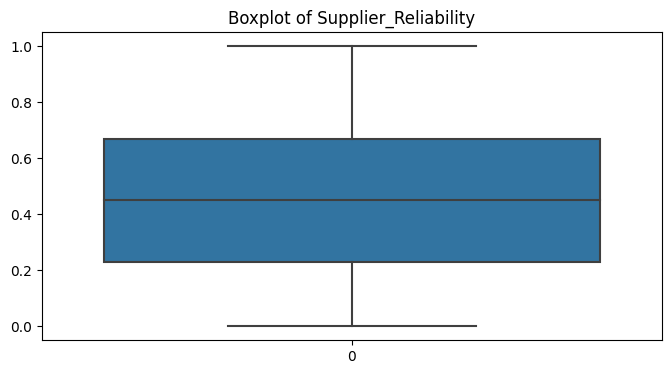

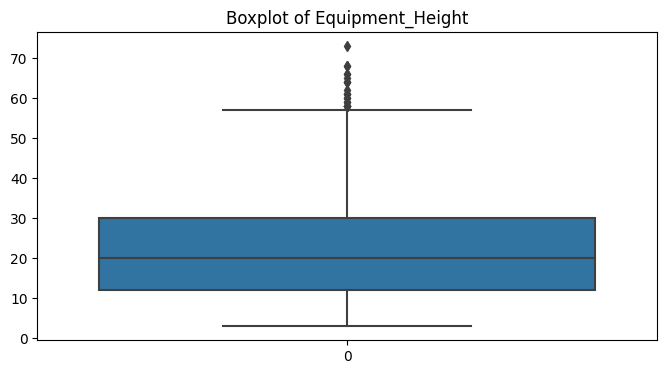

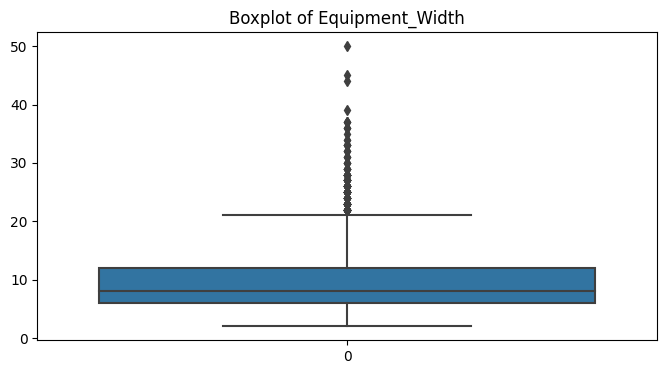

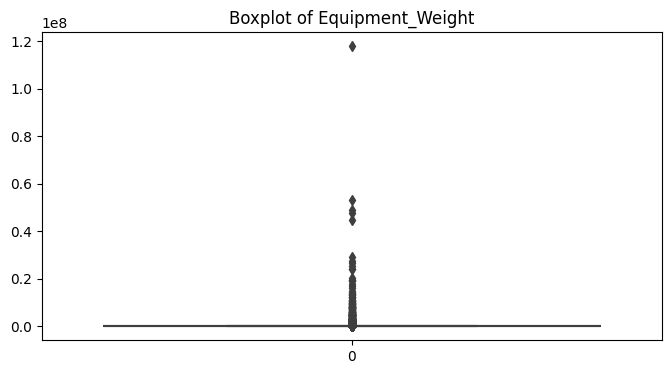

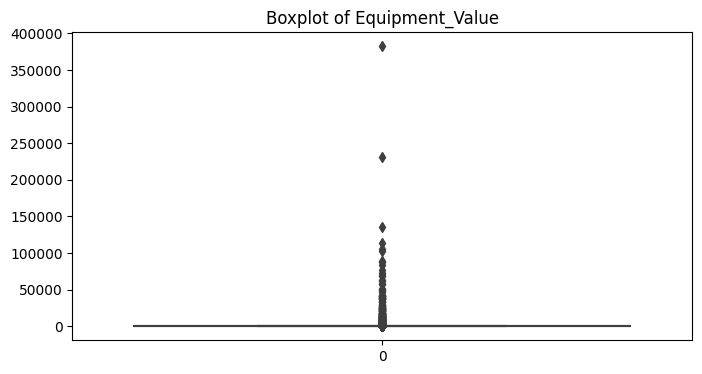

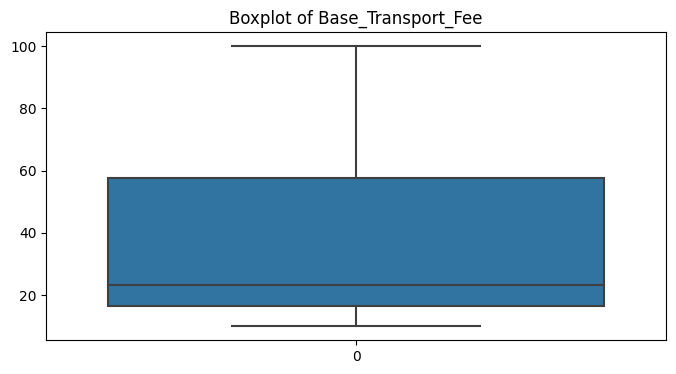

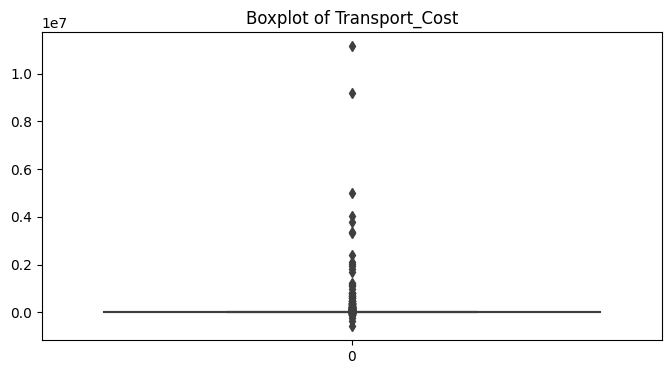

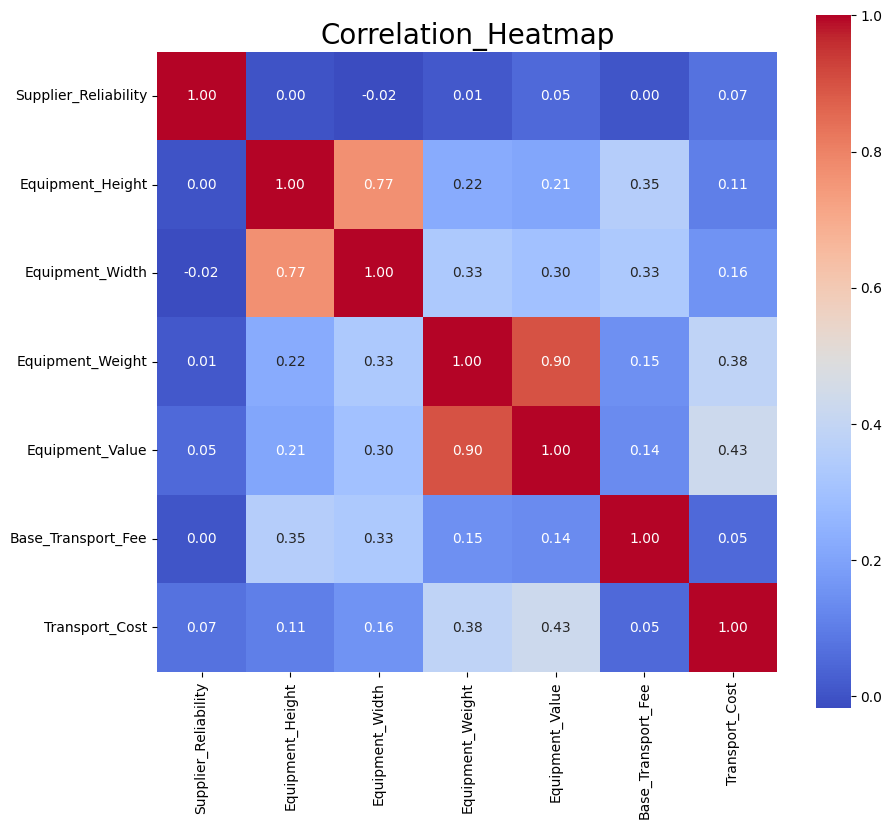

In [8]:
train_df.head()#Seeing 1st 5 rows of train.csv
train_df.shape #Seeing no. of rows and columns in train.csv
test_df.shape #Seeing no. of rows and columns in test.csv

train_df.info()

print(train_df.isnull() .sum()) #Gives total number of null values in each column

train_df.drop_duplicates(inplace=True) #Dropping duplicates if any

nullity_value_percentages_train_df=(train_df.isnull().sum()/train_df.shape[0])*100 #Null value percentages
print(nullity_value_percentages_train_df)

columns_with_null_values = nullity_value_percentages_train_df[nullity_value_percentages_train_df>0]
print(columns_with_null_values) #Columns with finite number of null values

print(train_df.describe().T)


import missingno as msno
msno.matrix(train_df)
plt.show()

num_cols = train_df.select_dtypes(include=['float64', 'int64']).columns #Numerical columns
cat_cols = train_df.select_dtypes(include=['object']).columns #Categorical columns
#Plotting distributions of numerical columns
for col in num_cols:
    plt.figure(figsize=(8, 4))
    plt.hist(train_df[col], bins=20, color='royalblue', alpha=0.6, edgecolor='black', density=True)
    sns.kdeplot(train_df[col], color='red', linewidth=2)
    plt.title(f'Distribution of {col}')
    plt.show()

#Plotting boxplots of numerical columns for outlier detection
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(train_df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()
     
#Plotting correlation heatmap of numerical columns
corr=train_df[num_cols].corr()
plt.figure(figsize=(10,9))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation_Heatmap", fontsize=20)
plt.show()

In [9]:


test_ids = test_df['Hospital_Id']
train_df.set_index('Hospital_Id', inplace=True)
test_df.set_index('Hospital_Id', inplace=True)

y_train = train_df["Transport_Cost"].copy()
X_train = train_df.drop(columns=["Transport_Cost"]).copy()

# Best-performing transformation: Clip and Log
y_train_transformed = np.log(y_train.clip(lower=CLIP_FLOOR))

# Combine for consistent feature engineering
combined_df = pd.concat([X_train, test_df], axis=0)



# Date Feature: Delivery Lag
combined_df['Order_Placed_Date'] = pd.to_datetime(combined_df['Order_Placed_Date'], format='%m/%d/%y', errors='coerce')
combined_df['Delivery_Date'] = pd.to_datetime(combined_df['Delivery_Date'], format='%m/%d/%y', errors='coerce')
combined_df['Delivery_Lag_Days'] = (combined_df['Delivery_Date'] - combined_df['Order_Placed_Date']).dt.days.fillna(0).astype(int)
combined_df.drop(columns=['Order_Placed_Date', 'Delivery_Date'], inplace=True)

# Equipment Volume
combined_df['Equipment_Volume'] = combined_df['Equipment_Height'] * combined_df['Equipment_Width']


combined_df['Equipment_Weight_Log'] = np.log1p(combined_df['Equipment_Weight'].fillna(combined_df['Equipment_Weight'].median()))
combined_df.drop(columns=['Equipment_Weight'], inplace=True)


# Drop noisy columns
cols_to_drop = ['Supplier_Name', 'Hospital_Location']
combined_df.drop(columns=[col for col in cols_to_drop if col in combined_df.columns], inplace=True)

# Binary Encoding
binary_map = {'Yes': 1, 'No': 0}
binary_cols = ['CrossBorder_Shipping', 'Urgent_Shipping', 'Installation_Service',
               'Fragile_Equipment', 'Rural_Hospital']
for col in binary_cols:
    combined_df[col] = combined_df[col].map(binary_map).fillna(0) 


# Categorical Feature Grouping
categorical_cols_to_group = ['Equipment_Type', 'Transport_Method', 'Hospital_Info']

for col in categorical_cols_to_group:
    # Calculate frequency of each category in the training set
    train_counts = combined_df.iloc[:len(X_train)][col].value_counts(normalize=True)
    # Identify categories to group
    low_freq_cats = train_counts[train_counts < FREQ_THRESHOLD].index
    # Replace low-frequency categories with 'Other'
    combined_df[col] = np.where(combined_df[col].isin(low_freq_cats), 'Other', combined_df[col])


# Re-separate the data
X_train_clean = combined_df.iloc[:len(X_train)]
X_test_clean = combined_df.iloc[len(X_train):]


# Define Preprocessing Pipeline
numeric_cols = X_train_clean.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train_clean.select_dtypes(include=['object']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in binary_cols]


# Define transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

# Using the stable Random Forest model with tuned parameters
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,             
    min_samples_leaf=5,       
    random_state=42,
    n_jobs=-1
)

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', rf_model)
])

# Train and Predict
rf_pipeline.fit(X_train_clean, y_train_transformed)
predictions_log = rf_pipeline.predict(X_test_clean)

neg_rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

# Perform 5-Fold Cross-Validation on the log-transformed target
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_pipeline, X_train_clean, y_train_transformed, 
                            scoring=neg_rmse_scorer, cv=kf, n_jobs=-1)

# The result is negative RMSE, so we make it positive.
mean_cv_rmse_log = -np.mean(cv_scores)
std_cv_rmse_log = np.std(cv_scores) 
print(f"Mean of CV RMSE: {mean_cv_rmse_log:.4f} ")
print(f"Standard Deviation of CV RMSE: {std_cv_rmse_log:.4f}")

# Inverse Transform Predictions
predictions_original_scale = np.exp(predictions_log) # Invert the Clip-and-Log transform


submission_df = pd.DataFrame({
    'Hospital_Id': test_ids,
    'Transport_Cost': predictions_original_scale
})

submission_df.to_csv("submission.csv", index=False)


Mean of CV RMSE: 2.0750 
Standard Deviation of CV RMSE: 0.0474
